In [1]:
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
batch_size = 100
n_classes = 100
n_epochs = 100

In [33]:
# Source: "https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb"


class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 16, 
                               kernel_size = 5)
        
        self.fc_1 = nn.Linear(16 * 16 * 16, 240)
        self.fc_2 = nn.Linear(240, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        #x = [batch size, 1, 28, 28]
        
        x = self.conv1(x)
        
        #x = [batch size, 6, 24, 24]
        
        x = F.max_pool2d(x, kernel_size = 2)
        
        #x = [batch size, 6, 12, 12]
        
        x = F.relu(x)
        
        x = self.conv2(x)
        
        #x = [batch size, 16, 8, 8]
        
        x = F.max_pool2d(x, kernel_size = 2)
        
        #x = [batch size, 16, 16, 16]
        
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x,output_size=16)
        x = x.view(x.shape[0], -1)
        
 
        
        h = x
        
        x = self.fc_1(x)
        

        x = F.relu(x)

        x = self.fc_2(x)
        

        
        x = F.relu(x)

        x = self.fc_3(x)


        
        return x

In [34]:


def lenet(output_dim=n_classes):
    model = LeNet(output_dim)
    if(torch.cuda.is_available()):
      model = model.cuda()
    return model

In [35]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [36]:
dataset = {
    'train': datasets.CIFAR100(
      root="data",
      #train=True,
      download=True,
      transform=image_transforms['train'],
    ),
    'test': datasets.CIFAR100(
      root="data",
      train=False,
      download=True,
      transform=image_transforms['test'],
    )
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size,pin_memory=True, shuffle=True),
    'test': DataLoader(dataset['test'], batch_size=batch_size, shuffle=True)
}

Files already downloaded and verified
Files already downloaded and verified


In [37]:
model = lenet(n_classes)

In [38]:
for name, param in model.named_parameters():
    param.requires_grad = True


In [39]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         if name == "layer2.2.conv1.weight":
#           print("hit")
#           break
#         param.requires_grad = False


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

In [41]:
losses = []
accuracies = []
r_a = []
r_l = []
model.train()
for epoch in range(n_epochs):
  it = 0
  for data, targets in dataloaders['train']:
    if torch.cuda.is_available():
      data = data.cuda()
      targets = targets.cuda()
    # Generate predictions
    
    out = model(data)
    # Calculate loss
    
    loss = criterion(out, targets)

    loss.backward()

    accr = (torch.argmax(out,axis=1) == targets).detach().sum().item() / batch_size
    accuracies.append(accr)
    losses.append( loss.item() )
    # Backpropagation
    # Update model parameters
    optimizer.step()
    if it % 20 == 19:
      r_a.append(sum(accuracies[-20:]) / 20)
      r_l.append(sum(losses[-20:]) / 20)
      print(epoch,it,r_a[-1],r_l[-1])
    it += 1
    del data
    del targets
    del out
    del loss


0 19 0.009 4.606790590286255
0 39 0.008999999999999998 4.606644940376282
0 59 0.013500000000000002 4.603760290145874
0 79 0.0095 4.6036961555480955
0 99 0.010499999999999999 4.60198712348938
0 119 0.0205 4.597152519226074
0 139 0.017500000000000005 4.5888381719589235
0 159 0.017000000000000005 4.566980862617493
0 179 0.014000000000000002 4.552139091491699
0 199 0.025000000000000005 4.53334379196167
0 219 0.029000000000000005 4.5025241613388065
0 239 0.03850000000000001 4.470076179504394
0 259 0.03450000000000001 4.407719326019287
0 279 0.05100000000000001 4.354919219017029
0 299 0.05750000000000001 4.310439348220825
0 319 0.052000000000000005 4.322149109840393
0 339 0.05000000000000001 4.24207067489624
0 359 0.05150000000000001 4.204461789131164
0 379 0.057500000000000016 4.192747282981872
0 399 0.065 4.15292922258377
0 419 0.06200000000000002 4.147952389717102
0 439 0.06250000000000001 4.105468797683716
0 459 0.07300000000000002 4.113160610198975
0 479 0.05950000000000002 4.1906296491

KeyboardInterrupt: ignored

In [42]:
def moving_average(x, w):
    return (np.convolve(x, np.ones(w), 'valid') / w)[::w]

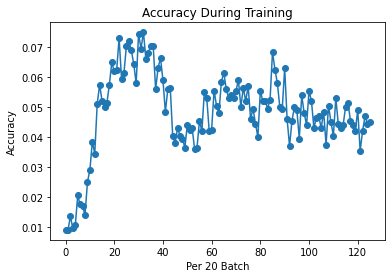

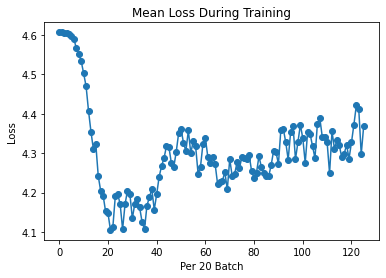

In [43]:
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Per 20 Batch')
plt.plot(r_a,marker='o')
plt.show()
plt.title('Mean Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Per 20 Batch')
plt.plot(r_l,marker='o')

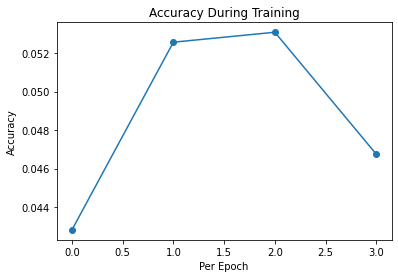

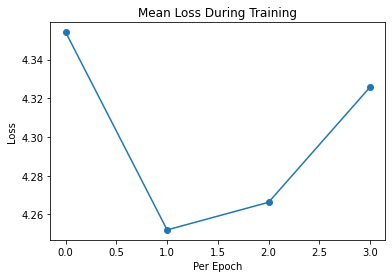

In [44]:
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Per Epoch')
plt.plot(moving_average(r_a,30),marker='o')
plt.show()
plt.title('Mean Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Per Epoch')
plt.plot(moving_average(r_l,30),marker='o')

In [46]:
model.eval()

cnt = 0
c_accr = 0
for data, targets in dataloaders['test']:
  # Generate predictions
  data = data.cuda()
  targets = targets.cuda()
  out = model(data)


  accr = (torch.argmax(out,axis=1) == targets).sum().item() / batch_size
  c_accr += (accr)

  cnt+=1
  del data
  del targets
  del out
c_accr /= cnt

print(c_accr) #Model Accuracy

0.03139999999999998
